In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import shap
from tqdm.notebook import tqdm

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Load financial time series data from a CSV file
data = pd.read_csv('AAPL_2006-01-01_to_2018-01-01.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [3]:
# Prepare the dataset
prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices)

In [4]:
# Split the data into train and test sets
train_size = int(len(scaled_prices) * 0.8)
train_data, test_data = scaled_prices[:train_size], scaled_prices[train_size:]

In [5]:
# Create sequences for input and output
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append((seq, target))
    return sequences

In [6]:
seq_length = 10
train_sequences = create_sequences(train_data, seq_length)
test_sequences = create_sequences(test_data, seq_length)

In [7]:
X_train, y_train = np.array([seq for seq, target in train_sequences]), np.array([target for seq, target in train_sequences])
X_test, y_test = np.array([seq for seq, target in test_sequences]), np.array([target for seq, target in test_sequences])

In [8]:
# Build and train an LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation='relu', input_shape=(seq_length, 1)),
    tf.keras.layers.Dense(1)
])

In [9]:
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
76/76 [==============================] - 1s 3ms/step - loss: 0.0243 - val_loss: 0.0171
Epoch 2/50
76/76 [==============================] - 0s 2ms/step - loss: 2.3052e-04 - val_loss: 0.0012
Epoch 3/50
76/76 [==============================] - 0s 2ms/step - loss: 1.3003e-04 - val_loss: 0.0012
Epoch 4/50
76/76 [==============================] - 0s 2ms/step - loss: 1.2354e-04 - val_loss: 7.3894e-04
Epoch 5/50
76/76 [==============================] - 0s 2ms/step - loss: 1.2429e-04 - val_loss: 8.5569e-04
Epoch 6/50
76/76 [==============================] - 0s 2ms/step - loss: 1.1978e-04 - val_loss: 8.5445e-04
Epoch 7/50
76/76 [==============================] - 0s 2ms/step - loss: 1.1714e-04 - val_loss: 5.9074e-04
Epoch 8/50
76/76 [==============================] - 0s 2ms/step - loss: 1.1968e-04 - val_loss: 8.2094e-04
Epoch 9/50
76/76 [==============================] - 0s 2ms/step - loss: 1.1478e-04 - val_loss: 5.9384e-04
Epoch 10/50
76/76 [==============================] - 0s 2ms/st

In [10]:
# Make predictions
y_pred = model.predict(X_test)

19/19 [==============================] - 0s 793us/step


In [11]:
# Inverse transform predictions to original scale
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test)

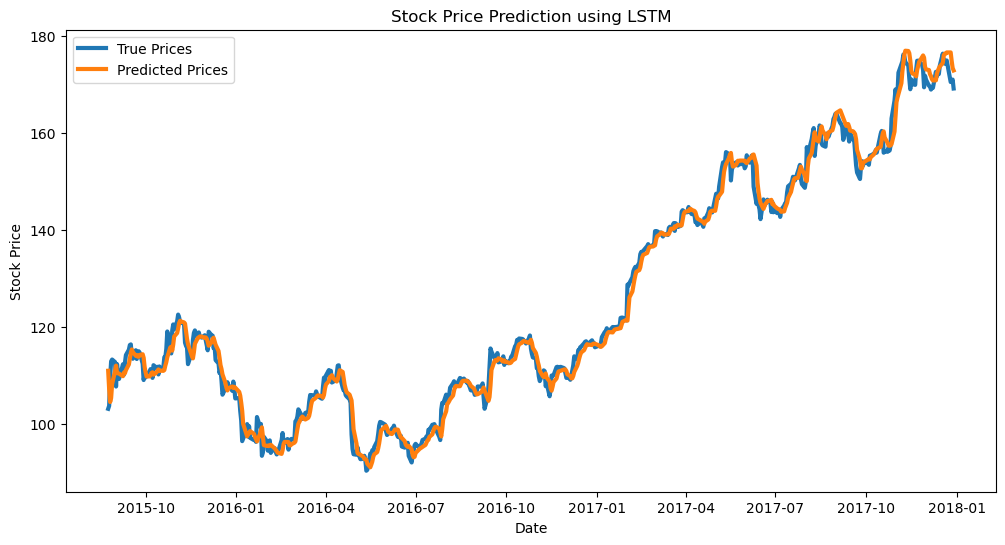

In [12]:
# Plot the predicted vs. actual stock prices
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size+seq_length:], y_test_original, label='True Prices', lw=3)
plt.plot(data.index[train_size+seq_length:], y_pred_original, label='Predicted Prices', lw=3)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction using LSTM')
plt.legend()
plt.show()

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
model.save('LSTM Prediction model.h5')

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
